In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
def clean_data_before_grouping(df):
    # Select and clean relevant columns, including the replicate column
    df = df[['sub_task', 'model', 'k', 'score', 'value', 'replicate']]
    df['model'] = df['model'].str.split('--clmbr_train').str[0]
    
    # Filter for AUROC scores
    df = df[(df['k'] == -1) & (df['score'] == 'auroc')]
    
    # Extract architecture and context length
    df['architecture'] = df['model'].apply(lambda x: x.split('-')[0])
    
    # Exclude BERT from the data
    df = df[df['architecture'] != 'bert']
    
    # Extract context length safely and ensure it's an integer
    df['context_length'] = df['model'].apply(lambda x: int(x.split('-')[2]) if len(x.split('-')) > 2 and x.split('-')[2].isdigit() else None)
    
    # Filter out rows related to GPT vocab size variations
    df = df[~df['model'].str.contains('--clmbr-')]
    
    # Return the cleaned data before grouping
    return df
    
# Assuming you load your data from a CSV file
df = pd.read_csv("/share/pi/nigam/users/migufuen/ehrshot-benchmark/EHRSHOT_ASSETS/results_ehrshot/guo_los/all_results.csv")

# Get the cleaned data before grouping
cleaned_data = clean_data_before_grouping(df)

# Display the cleaned data to inspect
print("Cleaned Data Before Grouping:")
print(cleaned_data.head())  # Display the first few rows


Cleaned Data Before Grouping:
    sub_task              model  k  score    value  replicate architecture  \
132  guo_los  hyena-large-16384 -1  auroc  0.76592          4        hyena   
141  guo_los  hyena-large-16384 -1  auroc  0.76592          3        hyena   
147  guo_los  hyena-large-16384 -1  auroc  0.76592          2        hyena   
156  guo_los  hyena-large-16384 -1  auroc  0.76592          1        hyena   
165  guo_los  hyena-large-16384 -1  auroc  0.76592          0        hyena   

     context_length  
132           16384  
141           16384  
147           16384  
156           16384  
165           16384  


/tmp/ipykernel_2950023/1913627976.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['model'] = df['model'].str.split('--clmbr_train').str[0]


In [3]:
cleaned_data

,sub_task,model,k,score,value,replicate,architecture,context_length
132,guo_los,hyena-large-16384,-1,auroc,0.765920,4,hyena,16384
141,guo_los,hyena-large-16384,-1,auroc,0.765920,3,hyena,16384
147,guo_los,hyena-large-16384,-1,auroc,0.765920,2,hyena,16384
156,guo_los,hyena-large-16384,-1,auroc,0.765920,1,hyena,16384
165,guo_los,hyena-large-16384,-1,auroc,0.765920,0,hyena,16384
...,...,...,...,...,...,...,...,...
3135,guo_los,gpt-base-1024-att,-1,auroc,0.798483,0,gpt,1024
3138,guo_los,gpt-base-512-att,-1,auroc,0.813551,3,gpt,512
3141,guo_los,gpt-base-512-att,-1,auroc,0.813551,2,gpt,512
3144,guo_los,gpt-base-512-att,-1,auroc,0.813551,1,gpt,512


### Plot and CSV for different model architectures and context length (non-chexpert)

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Dictionary mapping folder names to actual task names
folder_to_name_mapping = {
    'guo_los': 'Long LOS',
    'guo_icu': 'ICU Prediction',
    'guo_readmission': '30-Day Readmission',
    'lab_anemia': 'Anemia',
    'lab_hyperkalemia': 'Hyperkalemia',
    'lab_hypoglycemia': 'Hypoglycemia',
    'lab_hyponatremia': 'Hyponatremia',
    'lab_thrombocytopenia': 'Thrombocytopenia',
    'new_acutemi': 'Acute MI',
    'new_celiac': 'Celiac',
    'new_hyperlipidemia': 'Hyperlipidemia',
    'new_hypertension': 'Hypertension',
    'new_lupus': 'Lupus',
    'new_pancan': 'Pancreatic Cancer',
    'chexpert': 'Chexpert'
}

In [6]:
# Updated dictionary with max(Logistic Regression, GBM, Random Forest) as baseline
baseline_and_sota = {
    'ICU Prediction': {
        'CLMBR': 0.848,
        'Logistic Regression': 0.701,
        'GBM': 0.799,
        'Random Forest': 0.721
    },
    'Long LOS': {
        'CLMBR': 0.814,
        'Logistic Regression': 0.704,
        'GBM': 0.783,
        'Random Forest': 0.758
    },
    '30-Day Readmission': {
        'CLMBR': 0.810,
        'Logistic Regression': 0.751,
        'GBM': 0.741,
        'Random Forest': 0.775
    },
    'Anemia': {
        'CLMBR': 0.962,
        'Logistic Regression': 0.739,
        'GBM': 0.814,
        'Random Forest': 0.799
    },
    'Hyponatremia': {
        'CLMBR': 0.760,
        'Logistic Regression': 0.612,
        'GBM': 0.659,
        'Random Forest': 0.631
    },
    'Thrombocytopenia': {
        'CLMBR': 0.852,
        'Logistic Regression': 0.753,
        'GBM': 0.815,
        'Random Forest': 0.811
    },
    'Hyperkalemia': {
        'CLMBR': 0.792,
        'Logistic Regression': 0.658,
        'GBM': 0.727,
        'Random Forest': 0.66
    },
    'Hypoglycemia': {
        'CLMBR': 0.794,
        'Logistic Regression': 0.582,
        'GBM': 0.627,
        'Random Forest': 0.606
    },
    'Acute MI': {
        'CLMBR': 0.729,
        'Logistic Regression': 0.678,
        'GBM': 0.725,
        'Random Forest': 0.741
    },
    'Lupus': {
        'CLMBR': 0.747,
        'Logistic Regression': 0.793,
        'GBM': 0.703,
        'Random Forest': 0.587
    },
    'Hyperlipidemia': {
        'CLMBR': 0.675,
        'Logistic Regression': 0.720,
        'GBM': 0.699,
        'Random Forest': 0.625
    },
    'Hypertension': {
        'CLMBR': 0.718,
        'Logistic Regression': 0.689,
        'GBM': 0.637,
        'Random Forest': 0.627
    },
    'Celiac': {
        'CLMBR': 0.557,
        'Logistic Regression': 0.758,
        'GBM': 0.723,
        'Random Forest': 0.639
    },
    'Pancreatic Cancer': {
        'CLMBR': 0.813,
        'Logistic Regression': 0.856,
        'GBM': 0.824,
        'Random Forest': 0.885
    },
    'Chexpert': {
        'CLMBR': 0.713,
        'Logistic Regression': 0.647,
        'GBM': 0.656,
        'Random Forest': 0.631
    }
}

In [7]:
chexpert_sota_and_baseline = {
    'Lung Opacity': {
        'CLMBR': 0.709,
        'Logistic Regression': 0.637,
        'GBM': 0.675,
        'Random Forest': 0.652
    },
    'Pleural Effusion': {
        'CLMBR': 0.754,
        'Logistic Regression': 0.676,
        'GBM': 0.673,
        'Random Forest': 0.678
    },
    'Consolidation': {
        'CLMBR': 0.680,
        'Logistic Regression': 0.615,
        'GBM': 0.604,
        'Random Forest': 0.617
    },
    'Pleural Other': {
        'CLMBR': 0.714,
        'Logistic Regression': 0.735,
        'GBM': 0.731,
        'Random Forest': 0.617
    },
    'Pneumothorax': {
        'CLMBR': 0.823,
        'Logistic Regression': 0.633,
        'GBM': 0.593,
        'Random Forest': 0.646
    },
    'Edema': {
        'CLMBR': 0.722,
        'Logistic Regression': 0.631,
        'GBM': 0.671,
        'Random Forest': 0.600
    },
    'Enlarged Cardiomediastinum': {
        'CLMBR': 0.640,
        'Logistic Regression': 0.691,
        'GBM': 0.656,
        'Random Forest': 0.568
    },
    'Cardiomegaly': {
        'CLMBR': 0.822,
        'Logistic Regression': 0.748,
        'GBM': 0.790,
        'Random Forest': 0.784
    },
    'Support Devices': {
        'CLMBR': 0.752,
        'Logistic Regression': 0.650,
        'GBM': 0.682,
        'Random Forest': 0.673
    },
    'Fracture': {
        'CLMBR': 0.734,
        'Logistic Regression': 0.670,
        'GBM': 0.710,
        'Random Forest': 0.607
    },
    'Pneumonia': {
        'CLMBR': 0.609,
        'Logistic Regression': 0.553,
        'GBM': 0.580,
        'Random Forest': 0.567
    },
    'Lung Lesion': {
        'CLMBR': 0.761,
        'Logistic Regression': 0.696,
        'GBM': 0.709,
        'Random Forest': 0.737
    },
    'Atelectasis': {
        'CLMBR': 0.655,
        'Logistic Regression': 0.538,
        'GBM': 0.515,
        'Random Forest': 0.502
    },
    'No Finding': {
        'CLMBR': 0.606,
        'Logistic Regression': 0.578,
        'GBM': 0.594,
        'Random Forest': 0.583
    }
}

In [8]:
def get_best_baseline(baselines_dict):
    auroc_clmbr = [d["CLMBR"] for d in baselines_dict.values()]
    mean_clmbr = sum(auroc_clmbr) / len(auroc_clmbr)

    auroc_lr = [d["Logistic Regression"] for d in baselines_dict.values()]
    mean_lr = sum(auroc_lr) / len(auroc_lr)

    auroc_gbm = [d["GBM"] for d in baselines_dict.values()]
    mean_gbm = sum(auroc_gbm) / len(auroc_gbm)

    auroc_rf = [d["Random Forest"] for d in baselines_dict.values()]
    mean_rf = sum(auroc_rf) / len(auroc_rf)

    print(f"CLMBR: {mean_clmbr}")
    print(f"Logistic Regression: {mean_lr}")
    print(f"GBM: {mean_gbm}")
    print(f"Random Forest: {mean_rf}")

    average_best_value= max(mean_clmbr, mean_lr, mean_gbm, mean_rf)
    if average_best_value == mean_clmbr:
        best_model = "CLMBR"
    elif average_best_value == mean_lr:
        best_model = "Logistic Regression"
    elif average_best_value == mean_gbm:
        best_model = "GBM"
    else:
        best_model = "Random Forest"

    print(f"The best model is {best_model} with an average AUROC of {average_best_value}")
    return average_best_value

In [9]:
best_chexpert_avg_auroc = get_best_baseline(chexpert_sota_and_baseline)

CLMBR: 0.7129285714285712
Logistic Regression: 0.6465
GBM: 0.6559285714285714
Random Forest: 0.6307857142857144
The best model is CLMBR with an average AUROC of 0.7129285714285712


In [10]:
# Function to clean and extract relevant information from the CSV
def clean_and_extract(df):
    # Select and clean relevant columns, including the replicate column and bounds
    df = df[['sub_task', 'model', 'k', 'score', 'value', 'replicate', 'lower', 'upper']]
    df['model'] = df['model'].str.split('--clmbr_train').str[0]
    
    # Filter for AUROC scores
    df = df[(df['k'] == -1) & (df['score'] == 'auroc')]
    
    # Extract architecture and context length
    df['architecture'] = df['model'].apply(lambda x: x.split('-')[0])
    
    # Exclude BERT from the data
    df = df[df['architecture'] != 'bert']
    
    # Extract context length safely and ensure it's an integer
    df['context_length'] = df['model'].apply(lambda x: int(x.split('-')[2]) if len(x.split('-')) > 2 and x.split('-')[2].isdigit() else None)
    
    # Filter out rows related to GPT vocab size variations
    df = df[~df['model'].str.contains('--clmbr-')]
    
    # Group by task, model, architecture, context length, and calculate mean and bounds for replicates
    df_grouped = df.groupby(['sub_task', 'model', 'architecture', 'context_length']).agg(
        value_mean=('value', 'mean'),
        lower_bound=('lower', 'mean'),
        upper_bound=('upper', 'mean')
    ).reset_index()
    
    return df_grouped

In [11]:
# Function to process all tasks and return the combined summary
def process_all_tasks_for_plotting(include_models):
    ehrshot_dir = '/share/pi/nigam/users/migufuen/ehrshot-benchmark/EHRSHOT_ASSETS/results_ehrshot'  # Point to the 'ehrshot' directory
    combined_summary = pd.DataFrame()
    exclude_tasks = [
        # 'new_lupus',
        # 'new_celiac',
        'chexpert'
    ]
    for task_name in os.listdir(ehrshot_dir):
        task_path = os.path.join(ehrshot_dir, task_name)
        if os.path.isdir(task_path) and task_name not in exclude_tasks:
                try:
                    print(f"Processing task: {task_name}")
                    # Read and clean data
                    input_file = os.path.join(task_path, 'all_results.csv')
                    df = pd.read_csv(input_file)
                    df = df[df['model'].isin(include_models)]
                    df_cleaned = clean_and_extract(df)
                    df_cleaned['task_name'] = folder_to_name_mapping.get(task_name, task_name)
                    # Map the task name to a human-readable name
                    if task_name == 'chexpert':
                        df_cleaned = df_cleaned.groupby(['architecture', 'context_length', 'model', 'task_name']).agg({
                            'value_mean': 'mean',
                            'lower_bound': 'mean',
                            'upper_bound': 'mean'
                        }).reset_index()
                        df_cleaned['sub_task'] = df_cleaned['task_name']
                    
                    
                    # Combine with the overall summary
                    combined_summary = pd.concat([combined_summary, df_cleaned], ignore_index=True)
                    # print(combined_summary.head())  # Debug: Inspect the first few rows
                    
                except Exception as e:
                    print(f"Failed to process task {task_name}: {e}")
    combined_summary ['architecture'] = combined_summary['architecture'].replace('gpt2', 'gpt')

    # combined_summary = combined_summary[combined_summary['model'].isin(include_models)]
    return combined_summary

In [12]:
# Merge the baseline and state-of-the-art AUROCs into the combined summary
def merge_baseline_sota(df, baseline_and_sota):
    # Create lists to store each baseline model's AUROC
    logistic_auroc_list = []
    gbm_auroc_list = []
    rf_auroc_list = []
    clmbr_auroc_list = []

    # Iterate over each task in the DataFrame
    for task_name in df['task_name'].unique():
        if task_name in baseline_and_sota:
            logistic_auroc = baseline_and_sota[task_name].get('Logistic Regression')
            gbm_auroc = baseline_and_sota[task_name].get('GBM')
            rf_auroc = baseline_and_sota[task_name].get('Random Forest')
            clmbr_auroc = baseline_and_sota[task_name].get('CLMBR')
        else:
            logistic_auroc, gbm_auroc, rf_auroc, clmbr_auroc = None, None, None, None
        
        logistic_auroc_list.extend([logistic_auroc] * len(df[df['task_name'] == task_name]))
        gbm_auroc_list.extend([gbm_auroc] * len(df[df['task_name'] == task_name]))
        rf_auroc_list.extend([rf_auroc] * len(df[df['task_name'] == task_name]))
        clmbr_auroc_list.extend([clmbr_auroc] * len(df[df['task_name'] == task_name]))

    # Add these lists as columns to the DataFrame
    df['Logistic_AUROC'] = logistic_auroc_list
    df['GBM_AUROC'] = gbm_auroc_list
    df['Random_Forest_AUROC'] = rf_auroc_list
    df['CLMBR_AUROC'] = clmbr_auroc_list
    
    return df

In [13]:
   # Function to plot all tasks in one frame
def plot_all_tasks_in_one_frame(combined_summary, save_path):
    # Set the Seaborn style for a dark grid background
    sns.set_style('whitegrid', rc={
        'xtick.bottom': True,
        'ytick.left': True,
    })
    
    # Sort context lengths uniformly
    combined_summary = combined_summary.sort_values('context_length')
    
    # Ensure all tasks have the same context lengths by adding missing ones with NaN
    context_lengths = combined_summary['context_length'].unique()
    architectures = combined_summary['architecture'].unique()
    
    # Reindex for each task to ensure consistency in context lengths
    reindexed_data = []
    for task_name, task_data in combined_summary.groupby('task_name'):
        task_data = task_data.drop_duplicates(subset=['context_length', 'architecture'])
        task_data = task_data.set_index(['context_length', 'architecture']).reindex(
            pd.MultiIndex.from_product([context_lengths, architectures], names=['context_length', 'architecture']),
            fill_value=np.nan
        ).reset_index()
        task_data['task_name'] = task_name
        reindexed_data.append(task_data)
    
    combined_summary = pd.concat(reindexed_data, ignore_index=True)
    
    # Facet grid with one plot per task
    g = sns.FacetGrid(combined_summary, col="task_name", col_wrap=3, height=4, aspect=1.5, sharey=False, sharex=False, despine=False)
    
    # Plotting the line plots with architecture as hue
    g.map(sns.lineplot, "context_length", "value_mean", "architecture", marker='o', errorbar=None, palette="tab10", linewidth=2)
    
    # Adjust the y-axis for each subplot individually
    for ax, (task_name, task_data) in zip(g.axes.flat, combined_summary.groupby('task_name')):
        sns.set_style('white', rc={
            'xtick.bottom': True,
            'ytick.left': True,
        })
        for spine in ax.spines.values():  # Add borders to the subplots
            spine.set_edgecolor('black')
            
        y_min = task_data['value_mean'].min()
        y_max = task_data['value_mean'].max()
        
        # Adjust the axis limits dynamically
        ax.set_ylim([max(0.5, y_min - 0.05), min(1.0, y_max + 0.03)])
        ax.set_xlabel("Context Length")
        ax.set_ylabel("AUROC")
        
        # Find the row with the highest AUROC from the models
        best_row = task_data.loc[task_data['value_mean'].idxmax()]
        best_architecture = best_row['architecture']
        best_context_length = best_row['context_length']
        best_auroc = best_row['value_mean']
        
        # Get the baseline and state of the art AUROCs
        if task_name in baseline_and_sota:
            logistic_auroc = baseline_and_sota[task_name]['Logistic Regression']
            gbm_auroc = baseline_and_sota[task_name]['GBM']
            rf_auroc = baseline_and_sota[task_name]['Random Forest']
            clmbr_auroc = baseline_and_sota[task_name]['CLMBR']
            
            # Determine the best overall model (max of all baselines and CLMBR)
            baseline_max_auroc = max(logistic_auroc, gbm_auroc, rf_auroc, clmbr_auroc)
            if best_auroc < baseline_max_auroc:
                best_architecture = 'Prior SOTA'
                if baseline_max_auroc == clmbr_auroc:
                    best_auroc = clmbr_auroc
                elif baseline_max_auroc == logistic_auroc:
                    best_auroc = logistic_auroc
                elif baseline_max_auroc == gbm_auroc:
                    best_auroc = gbm_auroc
                else:
                    best_auroc = rf_auroc
                best_context_length = 'N/A'  # Baseline models and CLMBR are not dependent on context length
            
            # Plot the baseline models as horizontal dotted lines
            ax.axhline(y=baseline_max_auroc, color='purple', linestyle='--', linewidth=1.5, label='Prior SOTA')
                
        ax.set_title(
            f"{task_name}\nBest: {best_architecture}, {best_context_length}, AUROC={best_auroc:.3f}",
            fontsize=10,
            fontweight='bold',
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.3')
        )
    
    # Adjust layout to fit the title and increase spacing between subplots
    plt.subplots_adjust(top=0.89, hspace=0.4, wspace=0.3)
    
    # Add the legend manually for the baseline and state of the art
    unique_handles_labels = {}

    # Iterate over all axes in the figure
    for ax in g.axes.flat:
        handles, labels = ax.get_legend_handles_labels()
        
        # Add only unique labels and corresponding handles to the dictionary
        for handle, label in zip(handles, labels):
            if label not in unique_handles_labels:
                unique_handles_labels[label] = handle

    g.fig.legend(handles=unique_handles_labels.values(), labels=unique_handles_labels.keys(), loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=len(unique_handles_labels.keys()), fontsize=12)
    g.savefig(save_path)
    plt.show()
    
    combined_summary_sorted = merge_baseline_sota(combined_summary, baseline_and_sota)
    combined_summary_sorted = combined_summary_sorted.dropna()
    output_csv_path = "auroc_summary_table_context_length_architectire.csv"
    combined_summary_sorted = combined_summary_sorted.sort_values(by=['task_name', 'value_mean'], ascending=[True, False])
    combined_summary_sorted[['task_name', 'model', 'value_mean', 'lower_bound', 'upper_bound', 'Logistic_AUROC', 'GBM_AUROC', 'Random_Forest_AUROC', 'CLMBR_AUROC']].to_csv(output_csv_path, index=False)
    print(f"\nAUROC Summary Table saved to {output_csv_path}")

In [14]:
include_models_att = [
    'gpt-base-512-att--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'gpt-base-1024-att--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'gpt-base-2048-att--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'gpt-base-4096-att--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'hyena-large-1024-att--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'hyena-large-4096-att--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'hyena-large-8192-att--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'hyena-large-16384-att--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'llama-base-512-att--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'llama-base-1024-att--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'llama-base-2048-att--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'llama-base-4096-att--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'mamba-tiny-1024-att--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'mamba-tiny-4096-att--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'mamba-tiny-8192-att--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last',
    'mamba-tiny-16384-att--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
]
include_models = [
    'gpt2-base-512--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'gpt2-base-1024--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'gpt2-base-2048--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'gpt2-base-4096--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'hyena-large-1024--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'hyena-large-4096--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'hyena-large-8192--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'hyena-large-16384--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'llama-base-512--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'llama-base-1024--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'llama-base-2048--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'llama-base-4096--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'mamba-tiny-1024--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'mamba-tiny-4096--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
    'mamba-tiny-8192--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last',
    'mamba-tiny-16384--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last', 
]

In [15]:
combined_summary = process_all_tasks_for_plotting(include_models)
combined_summary_att = process_all_tasks_for_plotting(include_models_att)

Processing task: new_hypertension
Processing task: guo_los
Processing task: lab_hypoglycemia
Processing task: new_lupus
Processing task: lab_hyponatremia
Processing task: new_pancan
Processing task: lab_anemia
Processing task: new_acutemi
Processing task: guo_readmission
Processing task: lab_thrombocytopenia
Processing task: new_hyperlipidemia
Processing task: new_celiac
Processing task: lab_hyperkalemia
Processing task: guo_icu
Processing task: new_hypertension
Processing task: guo_los
Processing task: lab_hypoglycemia
Processing task: new_lupus
Processing task: lab_hyponatremia
Processing task: new_pancan
Processing task: lab_anemia
Processing task: new_acutemi
Processing task: guo_readmission
Processing task: lab_thrombocytopenia
Processing task: new_hyperlipidemia
Processing task: new_celiac
Processing task: lab_hyperkalemia
Processing task: guo_icu


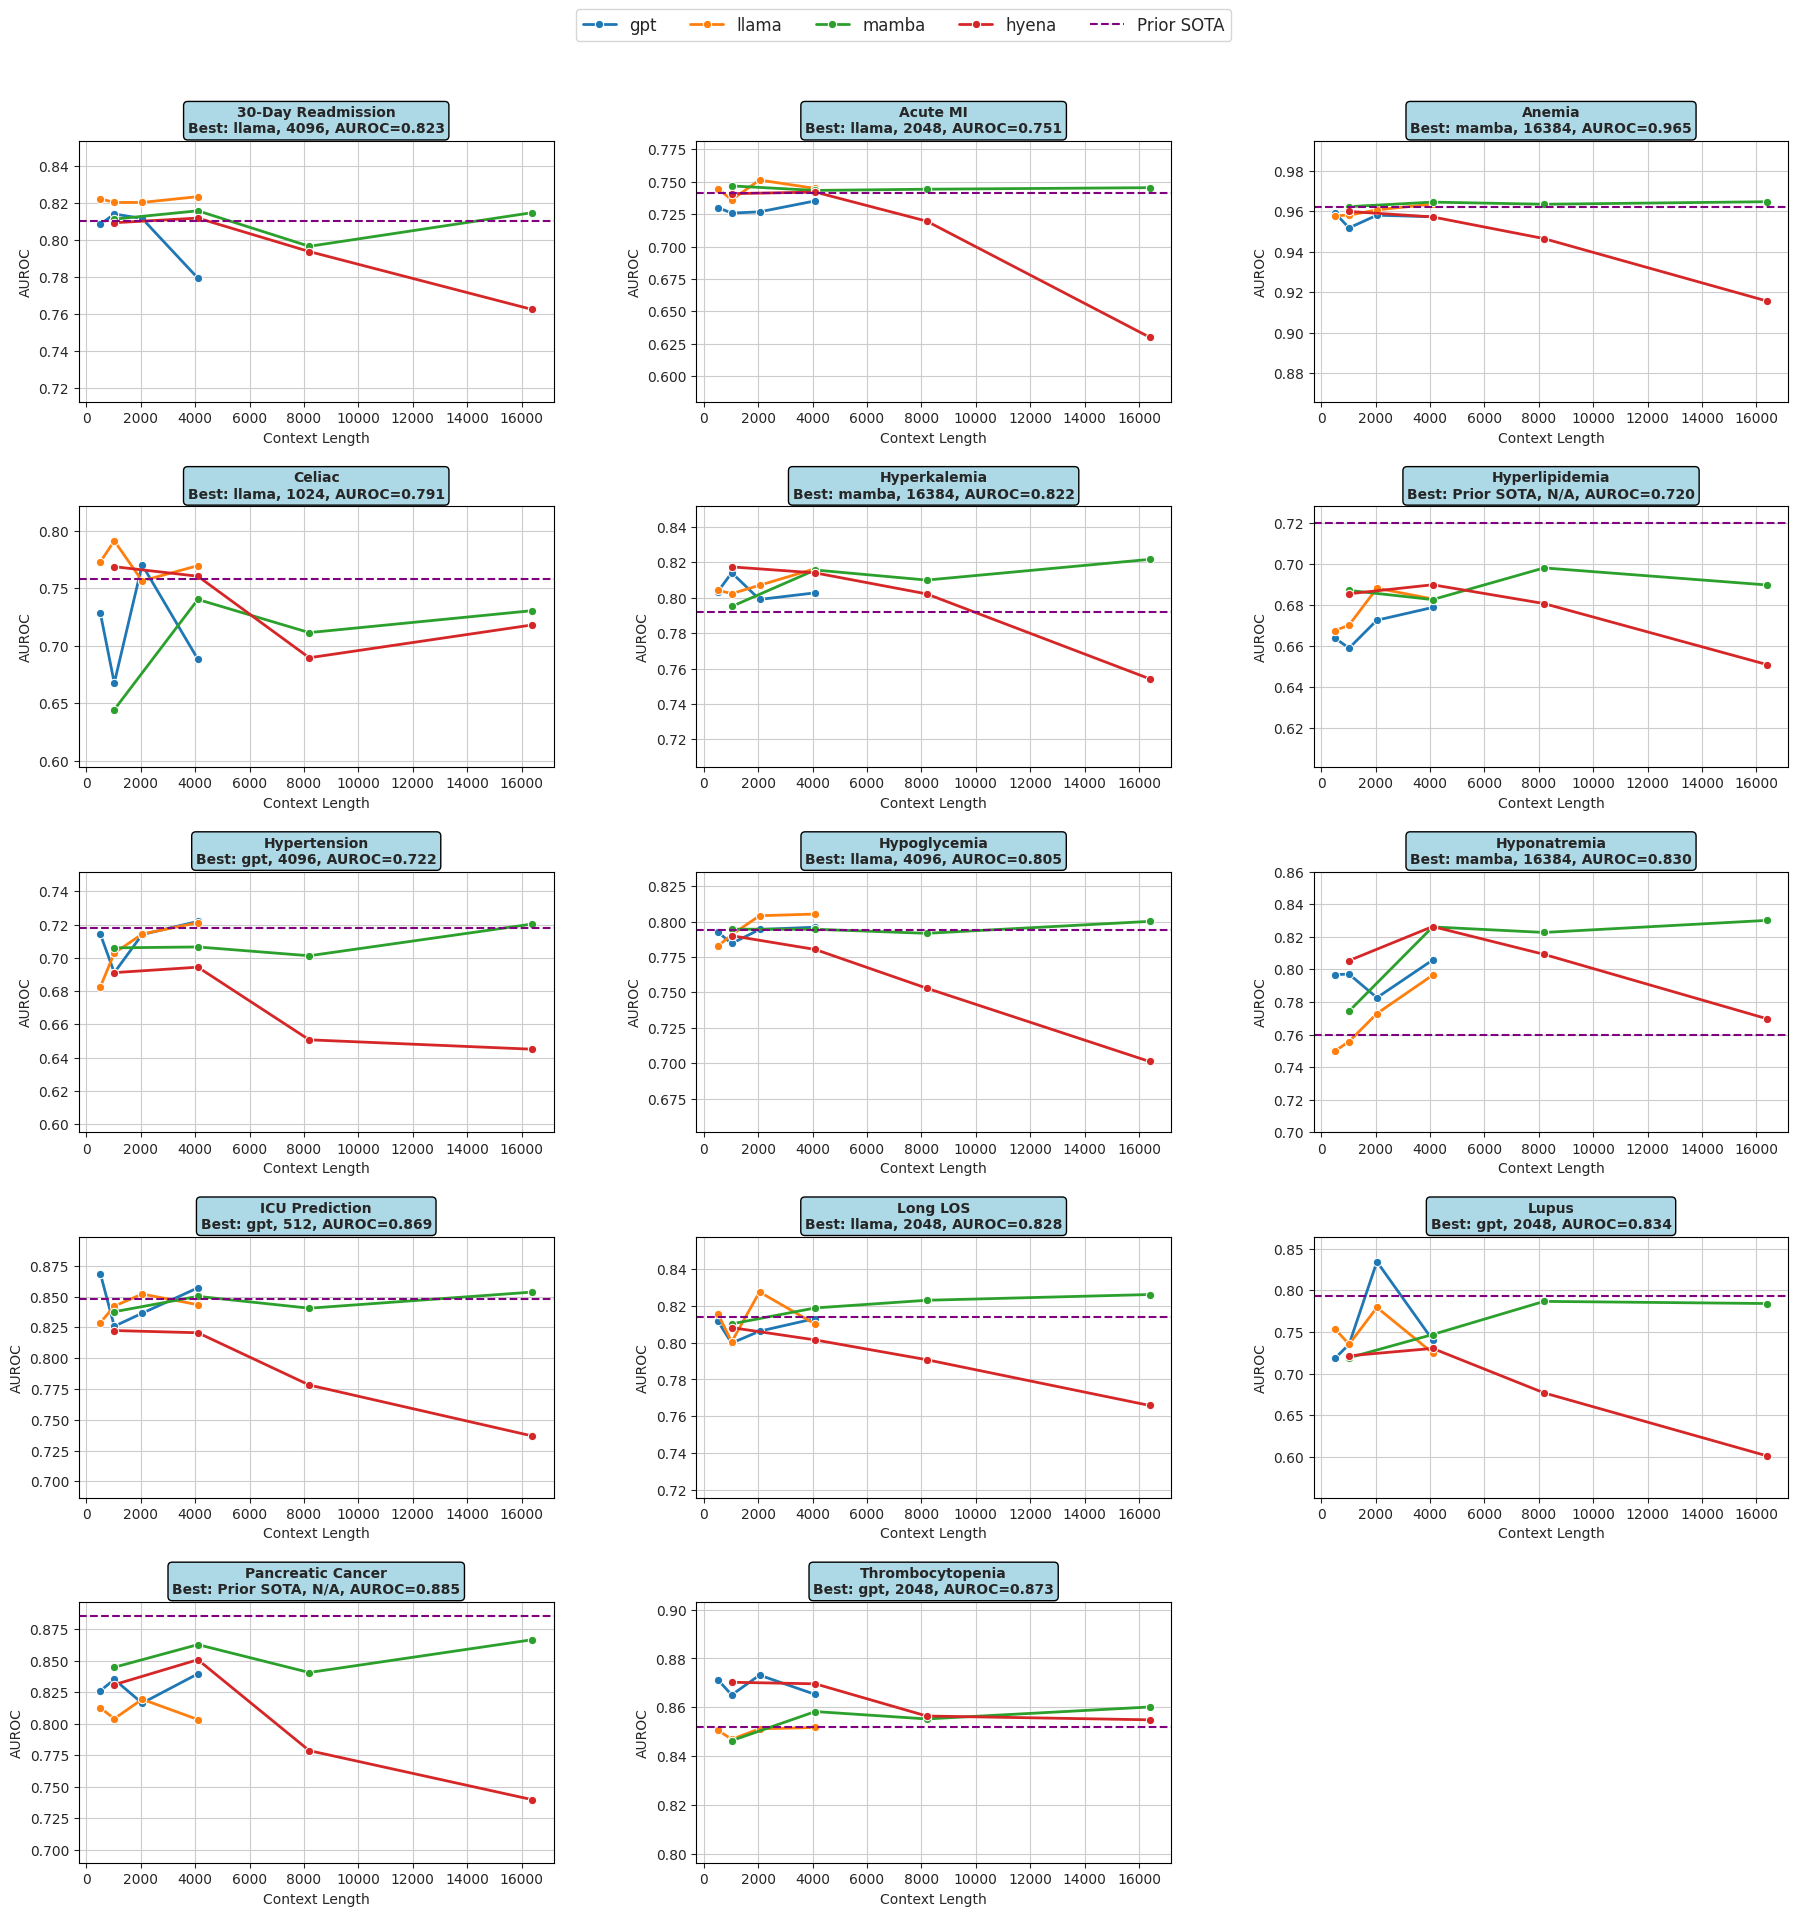


AUROC Summary Table saved to auroc_summary_table_context_length_architectire.csv


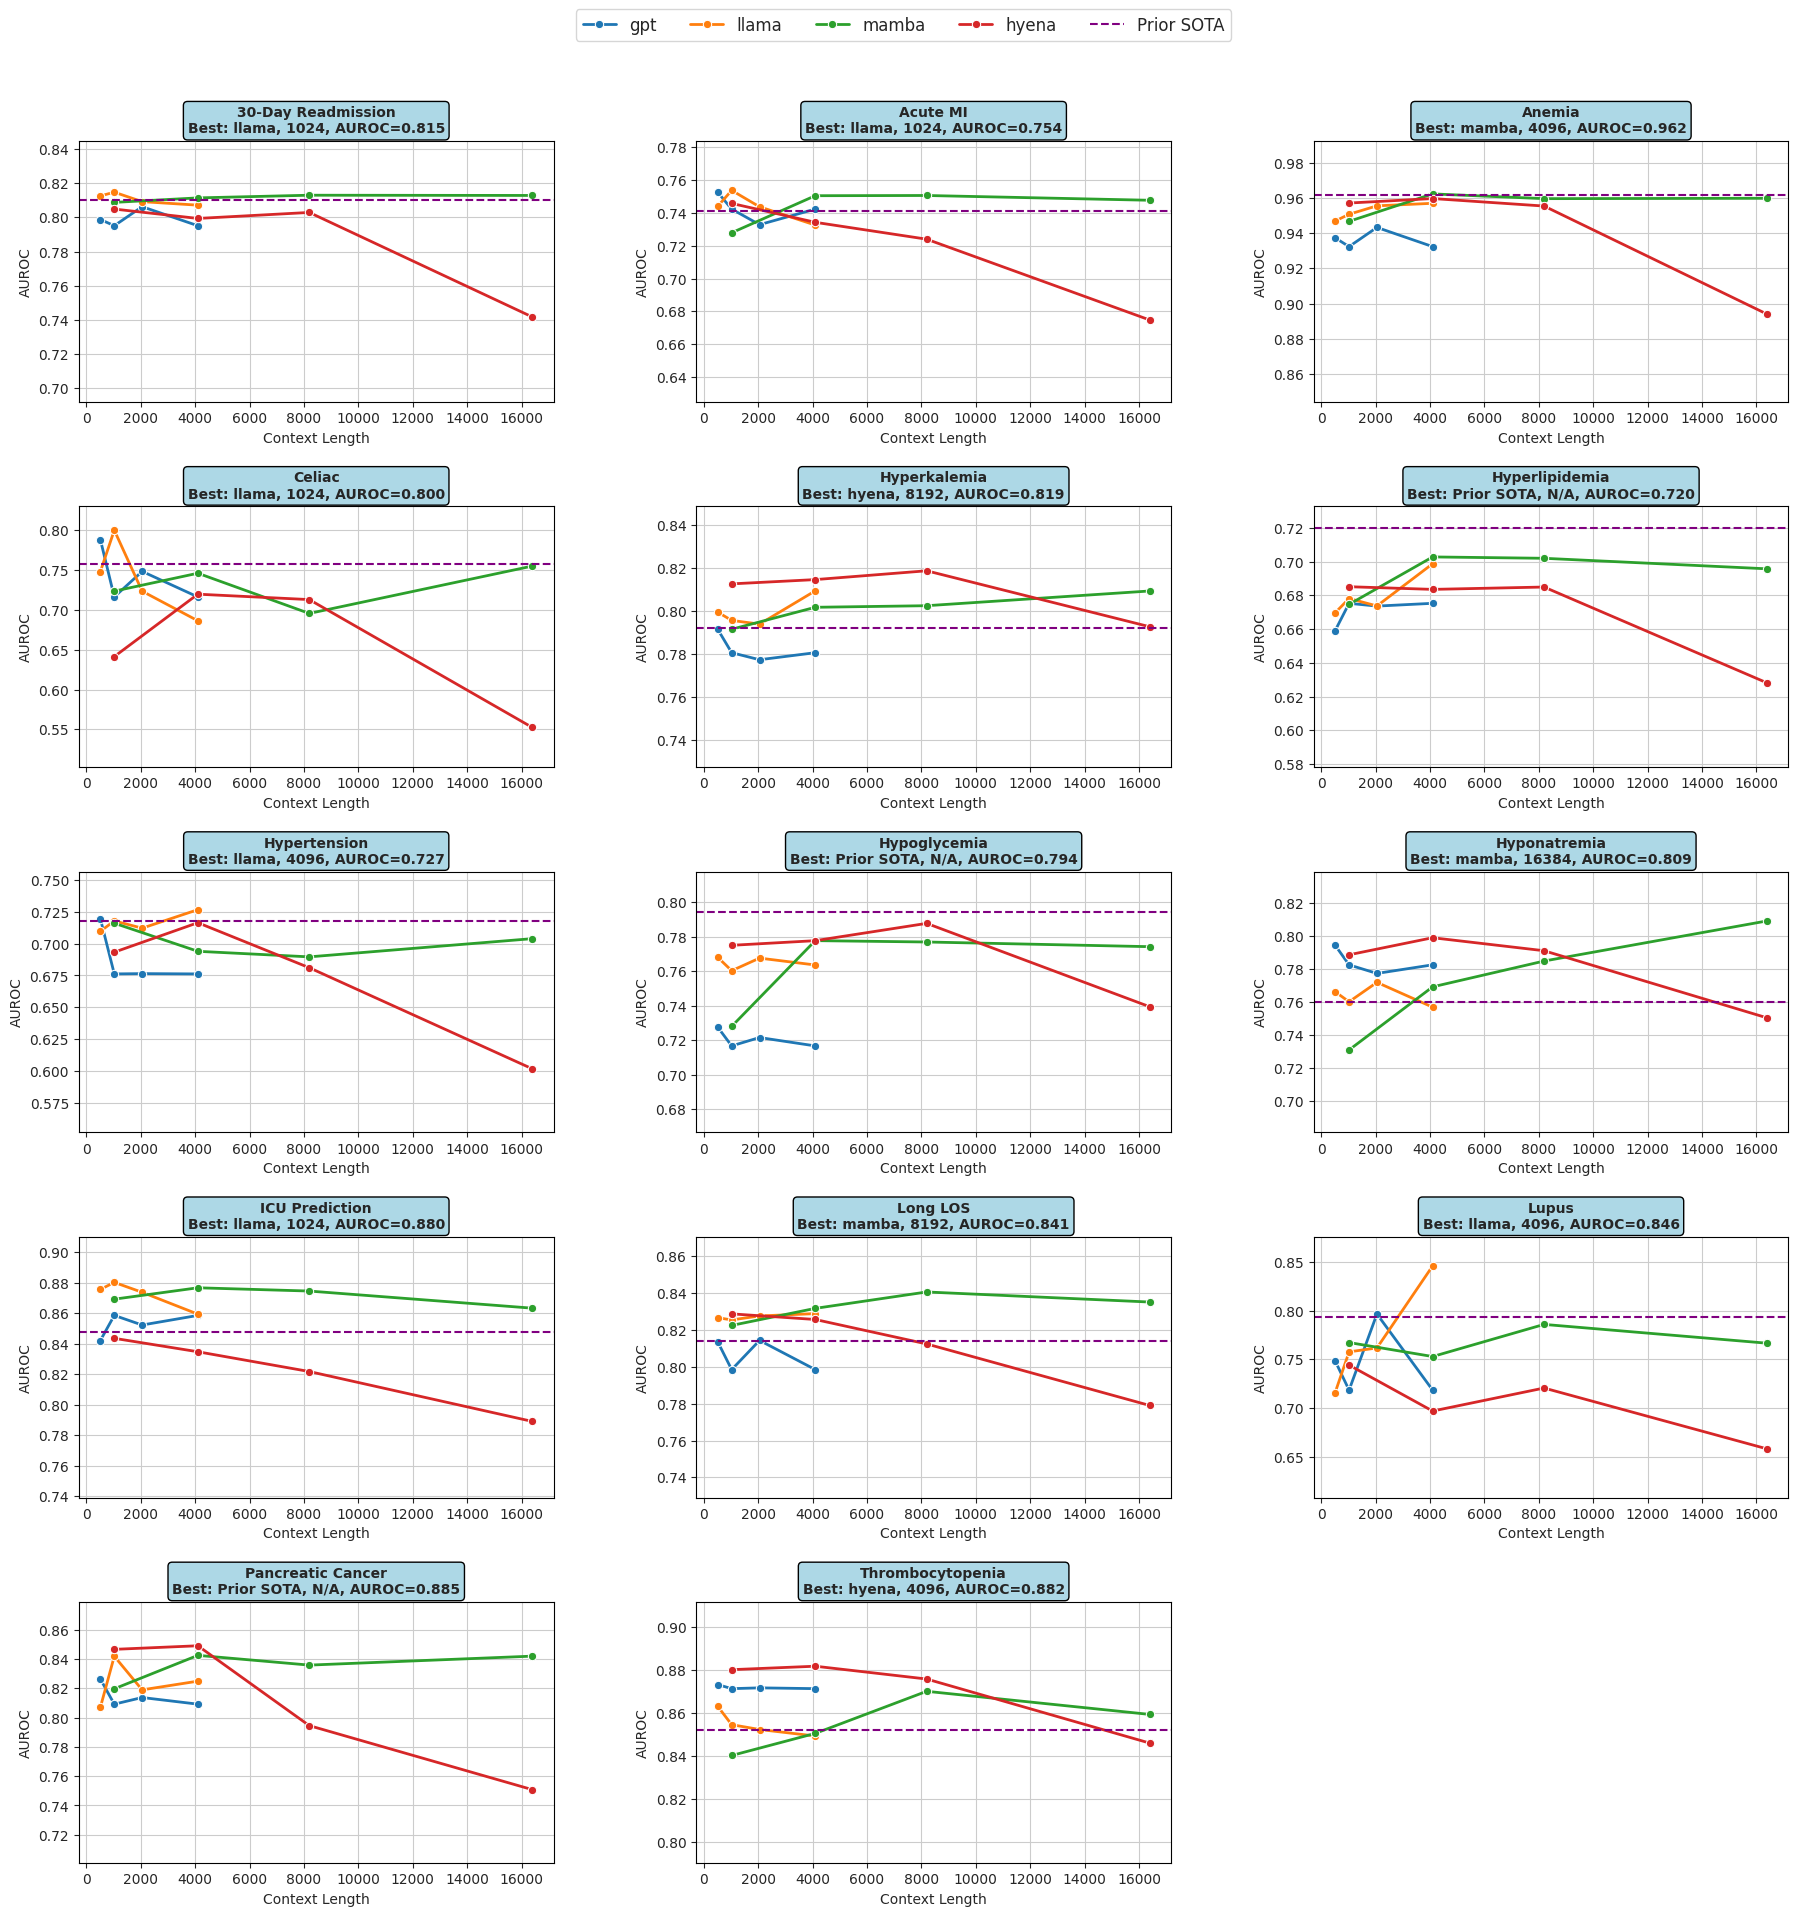


AUROC Summary Table saved to auroc_summary_table_context_length_architectire.csv


In [16]:
# First, process all tasks and get the combined summary
for df, file in [
    (combined_summary, "auroc_by_context_length_and_architecture_fixed.png"),
    (combined_summary_att, "auroc_by_context_length_and_architecture_fixed_att.png")
    ]:
    plot_all_tasks_in_one_frame(df, file)

CLMBR: 0.7765000000000002
Logistic Regression: 0.7138571428571427
GBM: 0.7340000000000001
Random Forest: 0.704642857142857
The best model is CLMBR with an average AUROC of 0.7765000000000002


<Figure size 1000x600 with 0 Axes>

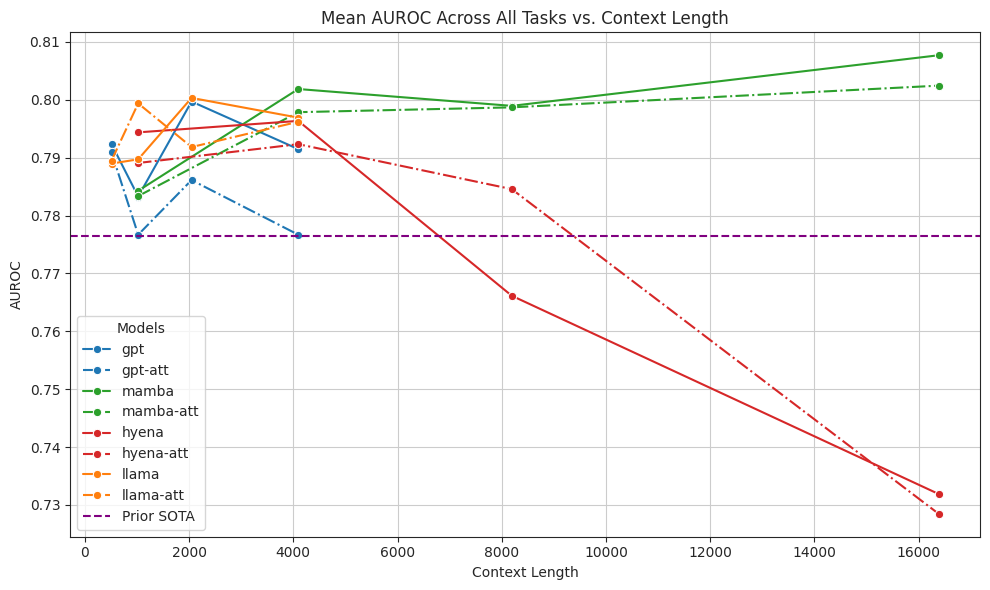

In [17]:
plt.figure(figsize=(10, 6))
tab10 = plt.get_cmap('tab10')

# Define a custom color palette using the first 4 colors from tab10
custom_palette = {
    'gpt': tab10(0),
    'gpt-att': tab10(0),
    'mamba': tab10(2),
    'mamba-att': tab10(2),
    'hyena': tab10(3),
    'hyena-att': tab10(3),
    'llama': tab10(1),
    'llama-att': tab10(1)
}

# Create an empty DataFrame to store all the data
all_data = []

# Process both summaries
for df, is_att in [(combined_summary, False), (combined_summary_att, True)]:
    df_mean = df.groupby(['architecture', 'context_length'])['value_mean'].mean().reset_index()
    
    # Add suffix for attention models
    if is_att:
        df_mean['architecture'] = df_mean['architecture'] + '-att'
    
    # Add to the combined dataset
    all_data.append(df_mean)

# Combine all the data
final_df = pd.concat(all_data, ignore_index=True)

# Calculate average best value
keys_to_remove = ['Chexpert']
new_dict = {k: v for k, v in baseline_and_sota.items() if k not in keys_to_remove}
average_best_value = get_best_baseline(new_dict)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot for each architecture
for arch in ['gpt', 'mamba', 'hyena', 'llama']:
    # Plot regular version (solid line)
    mask = final_df['architecture'] == arch
    if mask.any():
        sns.lineplot(
            data=final_df[mask],
            x='context_length',
            y='value_mean',
            label=arch,
            color=custom_palette[arch],
            marker='o',
            linestyle='-'
        )
    
    # Plot attention version (dashed line)
    mask_att = final_df['architecture'] == f'{arch}-att'
    if mask_att.any():
        sns.lineplot(
            data=final_df[mask_att],
            x='context_length',
            y='value_mean',
            label=f'{arch}-att',
            color=custom_palette[f'{arch}-att'],
            marker='o',
            linestyle='-.'
        )

# Add global customizations
plt.axhline(y=average_best_value, color='purple', linestyle='--', label='Prior SOTA')
plt.title('Mean AUROC Across All Tasks vs. Context Length')
plt.xlabel('Context Length')
plt.ylabel('AUROC')
plt.legend(title='Models', loc='lower left')
# plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Adjust layout to prevent legend cutoff
plt.tight_layout()

# Show the plot
plt.show()